In [5]:
!pip install gym

In [0]:
import numpy as np
import random

class ExperienceReplay():
    def __init__(self, max_size = 50):
        self.experiences = []
        self.max_size = max_size

    def add_experience(self, experience):
        self.experiences.append(experience)
        if len(self.experiences) > self.max_size:
            self.experiences = self.experiences[len(self.experiences) - self.max_size:]

    def sample(self, size):
        return np.array(random.sample(self.experiences, size))

In [0]:
import tensorflow as tf
import numpy as np

class DQN():
    def __init__(self, model_arch, input_shape, output_units):
        self.input_shape = [-1]
        self.flattened_shape = 1
        for dim in input_shape:
            self.flattened_shape = self.flattened_shape * dim
            self.input_shape.append(dim)
        print(self.flattened_shape)
        self.output_units = output_units
        print(self.input_shape)
        self.create_model()
        
    def create_model(self):
        
        self.input_layer = tf.placeholder(shape = [None, self.flattened_shape], dtype = tf.float32)
        
        self.input = tf.reshape(self.input_layer, self.input_shape)

        self.dense1 = tf.layers.dense(inputs = self.input, units = 20, activation = tf.nn.relu)
        
        self.dense2 = tf.layers.dense(inputs = self.dense1, units = 10, activation = tf.nn.relu)

        self.Qout = tf.layers.dense(inputs = self.dense2, units = self.output_units, activation = None)
        
        self.prediction_value = tf.reduce_max(self.Qout, 1)
        
        self.prediction = tf.argmax(self.Qout, 1)
        
        self.targetQ = tf.placeholder(shape = [None], dtype = tf.float32)
        
        self.action = tf.placeholder(shape = [None], dtype = tf.int32)
        self.action_ont_hot = tf.one_hot(self.action, self.output_units, dtype = tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.action_ont_hot), axis = 1)
        
        self.temporal_difference = tf.square(self.targetQ - self.Q)
        
        self.loss = tf.reduce_mean(self.temporal_difference)
        
        self.optimizer = tf.train.AdamOptimizer(0.001)
        #self.optimizer = tf.train.GradientDescentOptimizer(0.001)
        
        self.train_model = self.optimizer.minimize(self.loss)       

In [0]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import mean_squared_error

import numpy as np
import time
import matplotlib.pyplot as plt

class DQL():
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate = 0.99, epsilon_min = 0.01, epsilon = 1.0, epsilon_decay = 0.99991, episodes = 500, rand_steps = 10000 , max_experience = 50000, update_freq = 4, max_ep_len = 200, print_every = 100):
        self.max_ep_len = max_ep_len
        self.print_every = print_every
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.episodes = episodes
        self.rand_steps = rand_steps
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.max_experience = max_experience
        self.epsilon_min = epsilon_min 
        self.learning_rate = learning_rate
        self.update_freq = update_freq
        self.model = self.create_model()
        self.experience = ExperienceReplay(self.max_experience)
    
    def create_model(self):
        return DQN(None, self.input_dim, self.output_dim)
    
    def process_state(self, state):
        state = state.reshape(1, state.shape[0])
        return state
    
    def play_game(self):
        init = tf.global_variables_initializer()
        env = gym.make('CartPole-v1')
        
        start_time = time.time()

        total_steps = 0
        all_rewards = []
        rewards_max = []
        rewards_avg = []
        
        with tf.Session() as sess:
            sess.run(init)
            for episode in range(self.episodes):

                state = env.reset()
                state = self.process_state(state)
                total_reward = 0.
                j = 0
                steps = 0

                while j < self.max_ep_len:
                    total_steps += 1
                    steps += 1
                    j += 1
                    if np.random.rand() < self.epsilon:
                        action = np.random.randint(0, self.output_dim)
                    else:
                        action = sess.run(self.model.prediction, feed_dict = {self.model.input_layer : state})[0]
                    new_state, reward, terminate, _ = env.step(action)
                    new_state = self.process_state(new_state)

                    if terminate is True:
                        reward = -1
                    
                    self.experience.add_experience([state, new_state, action, reward, terminate])

                    if total_steps > self.rand_steps:
                        if total_steps % self.update_freq == 0:
                            batch_size = 32
                            if len(self.experience.experiences) < 32:
                                batch_size = len(self.experience.experiences)
                            experiences = self.experience.sample(batch_size)
                          
                            done = -(experiences[:, 4] - 1)
                            target_rewards = experiences[:, 3] + self.learning_rate * \
                                                                  done * \
                                                                  sess.run(self.model.prediction_value, \
                                                                           feed_dict = {
                                                                                          self.model.input_layer : np.vstack(experiences[:, 1])
                                                                                       })
                            
                            #print(sess.run(self.model.Qout, feed_dict = {self.model.input_layer : np.vstack(experiences[:, 0])}))
                            #print(sess.run(self.model.Q, feed_dict = {self.model.input_layer : np.vstack(experiences[:, 0]), \
                            #                                          self.model.targetQ : target_rewards.tolist(), \
                            #                                          self.model.action : experiences[:, 2].tolist()}))
                            #print(target_rewards)
                            
                            sess.run(self.model.train_model, feed_dict = {self.model.input_layer : np.vstack(experiences[:, 0]), \
                                                                          self.model.targetQ : target_rewards.tolist(), \
                                                                          self.model.action : experiences[:, 2].tolist()})
                            #print(target_rewards.tolist())
                            #print(experiences[:, 2].tolist())
                            #print(np.vstack(experiences[:, 0]).shape)
                            #return 1,1
                            #print(done)
                            #print(np.vstack(experiences[:, 0]))
                            #print(target_rewards)
                            #print(experiences[:, 2])
                            #return 1,1
                            
                            #for s, new_s, a, r, t in experiences:
                            #    target_reward = r
                            #    if not t:
                            #        target_reward = r + self.learning_rate * sess.run(self.model.prediction_value, feed_dict = {self.model.input_layer : new_s})[0]
                            #    sess.run(self.model.train_model, feed_dict = {self.model.input_layer : s, \
                             #                                                 self.model.targetQ : [target_reward], \
                             #                                                 self.model.action : [a]})

                    state = new_state
                    total_reward += reward

                    if terminate is True:
                        break
                        
                all_rewards.append(total_reward)

                if episode != 0 and episode % self.print_every == 0:
                    print('REWARD in ' + str(episode) + ' : ' + str(total_reward) + ' EPSILON is : ' + str(self.epsilon) + ' max is: ' + str(max(all_rewards[episode - self.print_every : episode])) + ' mean is: ' + str(np.mean(all_rewards[episode - self.print_every : episode])))
                    rewards_max.append(max(all_rewards[episode - self.print_every : episode]))
                    rewards_avg.append(np.mean(all_rewards[episode - self.print_every : episode]))

                if total_steps > self.rand_steps:
                    if self.epsilon > self.epsilon_min:
                        self.epsilon *= self.epsilon_decay
            
        env.close()
        print('took: ' + str((time.time() - start_time) / 60.) + ' min.')
        return rewards_max, rewards_avg

TEST 2
---------------------
max episode len = 250
episodes = 2000
rand_stps = 10000
eps_decay = 0.9991
model -> [4,20,10,2] <br/>
took **28 minutes** to reach **epsilon = 0.269, max = 250, mean = 232.79**

TEST 1
----------------------
max episode len = 200 <br/>
episodes = 1000 <br/>
rand_steps = 10000 <br/>
esp_decay = 0.99991 <br/>
model -> [4,20,10,2] <br/>
learning_rate = 0.99 <br/>
train_every 4 <br/>

---------------------

TEST 3
------------------
max episode len = 300
episodes = 2000
rand_stps = 0
eps_decay = 0.9981
model -> [4,20,10,2] <br/>
took **34 minutes** to reach **epsilon = 0.02, max = 300, mean = 300**

In [11]:
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

dql = DQL([4], None, 2, episodes = 1000, rand_steps = 2000, epsilon_decay = 0.9981, max_ep_len = 50, print_every = 50)

4
[-1, 4]


In [12]:
r_max, r_avg = dql.play_game()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
REWARD in 50 : 9.0 EPSILON is : 1.0 max is: 46.0 mean is: 18.76
REWARD in 100 : 15.0 EPSILON is : 0.9867755703906039 max is: 50.0 mean is: 19.68
REWARD in 150 : 8.0 EPSILON is : 0.8972659114767886 max is: 50.0 mean is: 19.52
REWARD in 200 : 39.0 EPSILON is : 0.8158756054120678 max is: 44.0 mean is: 20.44
REWARD in 250 : 16.0 EPSILON is : 0.7418681518959364 max is: 50.0 mean is: 17.28
REWARD in 300 : 16.0 EPSILON is : 0.6745738580080745 max is: 33.0 mean is: 14.94
REWARD in 350 : 14.0 EPSILON is : 0.6133837781618758 max is: 50.0 mean is: 13.5
REWARD in 400 : 50.0 EPSILON is : 0.5577442037601671 max is: 50.0 mean is: 22.22
REWARD in 450 : 26.0 EPSILON is : 0.5071516526900504 max is: 50.0 mean is: 28.64
REWARD in 500 : 45.0 EPSILON is : 0.46114831331684814 max is: 50.0 mean is: 27.52
REWARD in 550 : 46.0 EPSILON is : 0.41931790174987627 max is: 50.0 mean is: 29.18
REWARD in 600 : 31.0 EPSILO

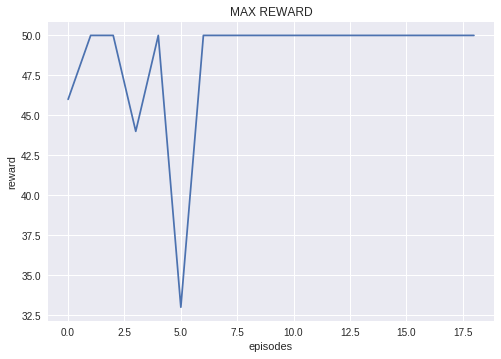

In [13]:
import matplotlib.pyplot as plt

plt.plot(np.squeeze(r_max))
plt.ylabel('reward')
plt.xlabel('episodes')
plt.title('MAX REWARD')
plt.show()

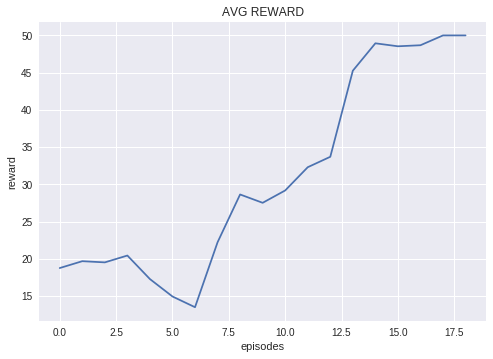

In [14]:
plt.plot(np.squeeze(r_avg))
plt.ylabel('reward')
plt.xlabel('episodes')
plt.title('AVG REWARD')
plt.show()